In [1]:
# 列出所有数据文件地址
file_name_list = ["subject_dystonia_hcc_area_lh.dat",
                  "subject_dystonia_hcc_area_rh.dat",
                  "subject_dystonia_hcc_curvind_lh.dat",
                  "subject_dystonia_hcc_curvind_rh.dat",
                  "subject_dystonia_hcc_foldind_lh.dat",
                  "subject_dystonia_hcc_foldind_rh.dat",
                  "subject_dystonia_hcc_gauscurv_lh.dat",
                  "subject_dystonia_hcc_gauscurv_rh.dat",
                  "subject_dystonia_hcc_meancurv_lh.dat",
                  "subject_dystonia_hcc_meancurv_rh.dat",
                  "subject_dystonia_hcc_Subcortical_volume_stats.txt",
                  "subject_dystonia_hcc_thickness_lh.dat",
                  "subject_dystonia_hcc_thickness_rh.dat",
                  "subject_dystonia_hcc_thicknessstd_lh.dat",
                  "subject_dystonia_hcc_thicknessstd_rh.dat",
                  "subject_dystonia_hcc_volume_lh.dat",
                  "subject_dystonia_hcc_volume_rh.dat"]

import pandas as pd

addr = "./features/"
data = pd.read_table(addr + file_name_list[0])

# 拼接所有数据
for i in range(1, len(file_name_list)):
    tmp = pd.read_table(addr + file_name_list[i])
    data = pd.concat([data, tmp], axis=1)

data.to_csv('./output_csv/data_step1_concat.csv', index=False)

# 用数字替代类别信息：BPS->0, CD->1, HCC->2
data_select = data
tmp = []
for a in data_select.iloc[:,0]:
    if 'BPS' in a: tmp.append(0)
    elif 'CD' in a: tmp.append(1)
    else: tmp.append(2) 
data_select.iloc[:,0] = tmp
data_select.rename(columns={'lh.aparc.area':'category'}, inplace=True)

# 删除无关变量
titles = data_select.columns
drop_list = ['BrainSegVolNotVent','eTIV','Measure:volume','BrainSegVol','lhCortexVol','rhCortexVol',
             'CortexVol','CerebralWhiteMatterVol','SubCortGrayVol','TotalGrayVol','SupraTentorialVol',
             'SupraTentorialVolNotVent','MaskVol','BrainSegVol-to-eTIV','MaskVol-to-eTIV',
             'SurfaceHoles','EstimatedTotalIntraCranialVol']
for item in drop_list:
    if item in titles: data_select.drop(item, axis=1, inplace=True)
for item in titles:
    if 'aparc' in item: data_select.drop(item, axis=1, inplace=True)

# 将data.columns信息写入文件file中
# with open('file.txt', 'w') as f: 
#     for item in titles: f.write(str(item) + '\n')

# data_select.to_csv('./output_csv/data_step2_delete.csv', index=False)

In [2]:
# 对所有数据进行最大最小归一化
from sklearn.preprocessing import MinMaxScaler

columns_list = data_select.columns.tolist()
data_Norm = data_select
data_Norm[columns_list[1:]] = MinMaxScaler().fit_transform(data[columns_list[1:]])

# data_Norm.to_csv('./output_csv/data_step3_norm.csv', index=False)

<Axes: >

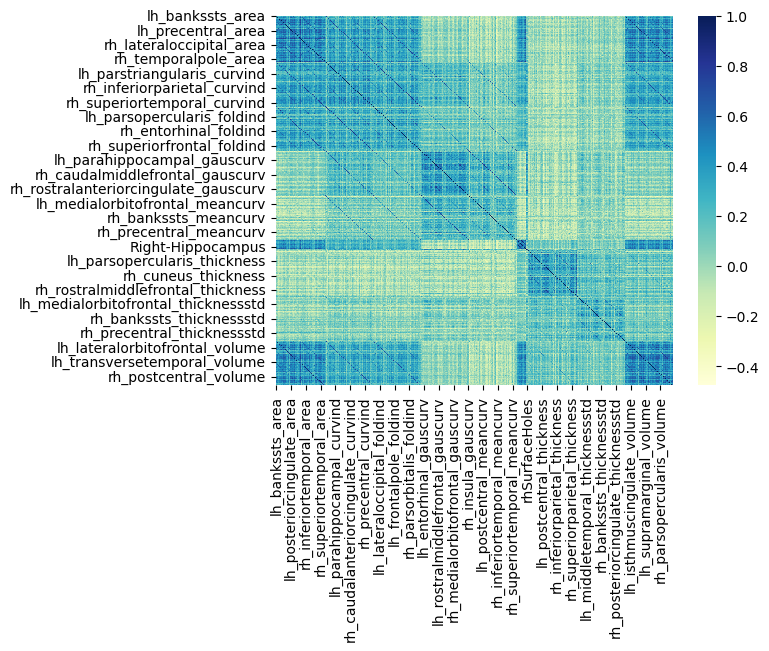

In [3]:
# 计算相关性矩阵
import seaborn as sns

corr_matrix = data_Norm.iloc[:,1:].corr()
sns.heatmap(corr_matrix, cmap="YlGnBu")

# 1 特征工程-降维-PCA * 2

In [4]:
# 进行pca降维，连续两次
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 准备进行降维的数据，剔除目标值
data_D_reduction = data_Norm.iloc[:, 1:]

X_pca = PCA(n_components=10).fit_transform(data_D_reduction)
X_pca2 = PCA(n_components=3).fit_transform(X_pca)

# 划分数据集
from sklearn.model_selection import train_test_split

X = X_pca2
y = data_Norm.iloc[:, 0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 1.1 使用svm进行多分类任务

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 设置网格搜索参数
param_grid = {
    'C': [1e-7, 1e-6, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [10]
}

grid_search = GridSearchCV(estimator=svm.SVC(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train.astype('int'))

# 输出网格搜索得到最优超参
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# 评测在测试集上的得分
best_model = grid_search.best_estimator_
test_score = best_model.score(X_val, LabelEncoder().fit_transform(y_val))
print("Test Score: ", test_score, "\nBest_model: ", best_model)

# 当前问题

1. 指标不好看，上个单元格中的score分数，即训练和测试的Accuracy值都不高
2. **因为是多分类任务，所以AUC算不出来**。这个是重点任务。

In [25]:
from sklearn.calibration import CalibratedClassifierCV

# 获取多分类任务的类别概率预测
calibrated_model = CalibratedClassifierCV(best_model, method='sigmoid')
calibrated_model.fit(X_train, y_train.astype('int'))
y_proba = calibrated_model.predict_proba(X_val)

In [ ]:
from  sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_auc_score(y_val.values, y_proba, multi_class='ovr')

In [ ]:
from  sklearn.metrics import roc_auc_score

# 在测试集上进行预测
y_scores = best_model.decision_function(X_val)

fpr, tpr, thresholds = roc_auc_score(y_val, y_proba, multi_class='ovr')

# 计算AUC
auc = roc_auc_score(y_val, y_scores, multi_class='ovr')

In [ ]:
# 绘制ROC曲线
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()